In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import matplotlib.cm as cm
from sklearn.decomposition import PCA
import scipy.stats
from sklearn import preprocessing
from sklearn.cluster import KMeans
from numpy import *
%matplotlib inline
plt.rcParams['font.sans-serif'] = [u'SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [2]:
#将csv文件读入df
df = pd.read_csv("./tripadvisor_review.csv")
#用有意义的列名重命名，方便后续数据处理
df.columns = ["user id", "art galleries", "dance clubs", "juice bars", "restaurants", "museums", "resorts", "parks/picnic spots", "beaches", "theaters", "religious institutions"]
print(df.head(5))
#查看前5行，了解数据的结构，发现数据完整，没有缺失值
print(df.info())

  user id  art galleries  dance clubs  juice bars  restaurants  museums  \
0  User 1           0.93          1.8        2.29         0.62     0.80   
1  User 2           1.02          2.2        2.66         0.64     1.42   
2  User 3           1.22          0.8        0.54         0.53     0.24   
3  User 4           0.45          1.8        0.29         0.57     0.46   
4  User 5           0.51          1.2        1.18         0.57     1.54   

   resorts  parks/picnic spots  beaches  theaters  religious institutions  
0     2.42                3.19     2.79      1.82                    2.42  
1     3.18                3.21     2.63      1.86                    2.32  
2     1.54                3.18     2.80      1.31                    2.50  
3     1.52                3.18     2.96      1.57                    2.86  
4     2.02                3.18     2.78      1.18                    2.54  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 980 entries, 0 to 979
Data columns (total 1

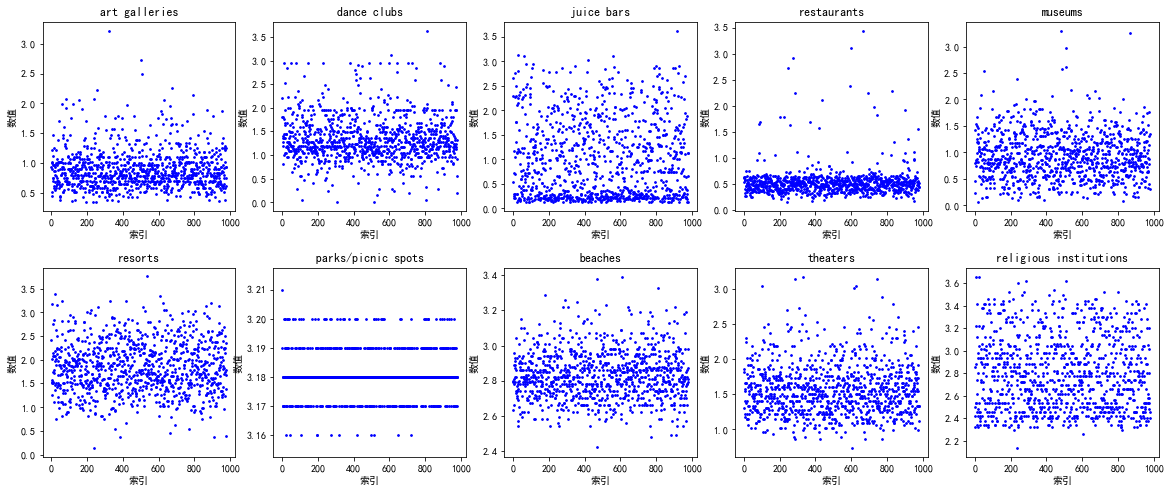

In [3]:
#画出10个属性索引与数值的散点图，观察数据大致的分布
plt.rcParams['figure.figsize'] = (20, 8) #设置画布大小为20*8
fig, ax = plt.subplots(2,5) #设置子图，为2*5方哥摆布
plt.subplots_adjust(wspace=0.2, hspace=0.3)
#画出每个属性的散点图
for i in range(10):
    num = i+1
    plt.subplot(2,5,num)
    plt.scatter(df.index, df[df.columns[i+1]], c="b", label=str(df.columns[i+1]), s=3)
    plt.ylabel("数值")
    plt.xlabel("索引")
    plt.title(df.columns[i+1])
plt.show()

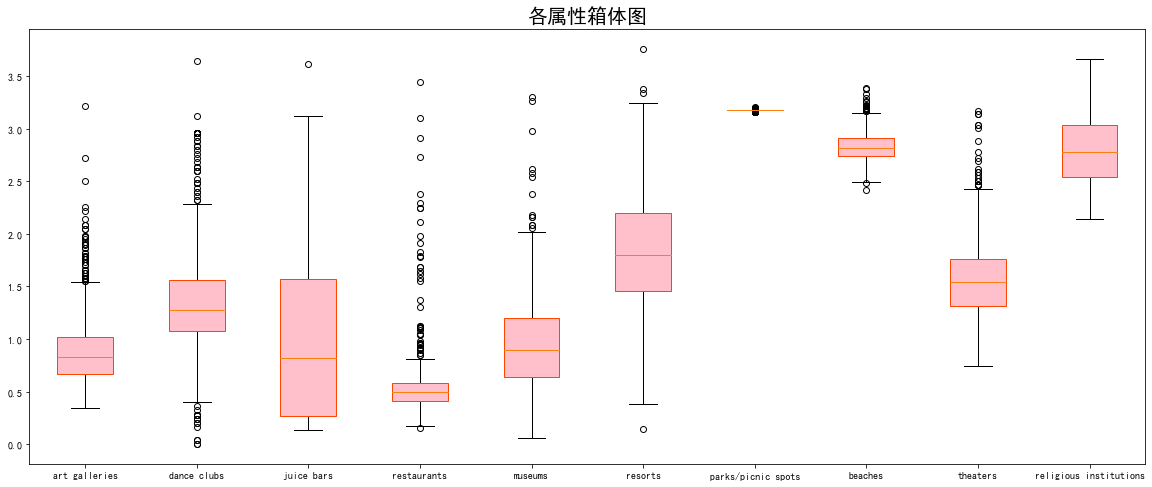

In [4]:
#由散点图发现存在离群点，用箱体图能更加细致地查看
#第一个属性"user id"在数据分析中并没有什么作用，所以使用去掉"user id"属性的data进行下一步分析
labels = ["art galleries", "dance clubs", "juice bars", "restaurants", "museums", "resorts", "parks/picnic spots", "beaches", "theaters", "religious institutions"]
data = df[labels]
box = []
#绘制箱体图
for i in range(10):
    box.append(data[data.columns[i]])
plt.title('各属性箱体图',fontsize=20) #标题，并设定字号大小
p = plt.boxplot(box, labels = labels, patch_artist = True, boxprops = {'color':'orangered','facecolor':'pink'})

In [5]:
#BoxFeature函数用于获取箱体图的具体信息
def BoxFeature(input_list):
    # 获取箱体图特征
    percentile = np.percentile(input_list, (25, 50, 75), interpolation='linear')
    #以下为箱线图的五个特征值
    Q1 = percentile[0] #上四分位数
    Q2= percentile[1]
    Q3 = percentile[2] #下四分位数
    IQR = Q3 - Q1 #四分位距
    ulim = Q3 + 1.5 * IQR #上限 非异常范围内的最大值
    llim = Q1 - 1.5 * IQR #下限 非异常范围内的最小值
    right_list = [] #正常数据列表
    Error_Point_num = 0 #异常点个数
    value_total = 0 
    average_num = 0 #平均值
    for item in input_list:
        if item < llim or item > ulim:
            Error_Point_num += 1
        else:
            right_list.append(item)
        value_total += item
        average_num += 1
    average_value = value_total/average_num
    # 特征值保留一位小数
    out_list = [average_value,min(right_list), Q1, Q2, Q3, max(right_list)]
    # print(out_list)
    return out_list,Error_Point_num
BoxFeature(df["art galleries"])

([0.8931938775510203, 0.34, 0.67, 0.83, 1.02, 1.54], 47)

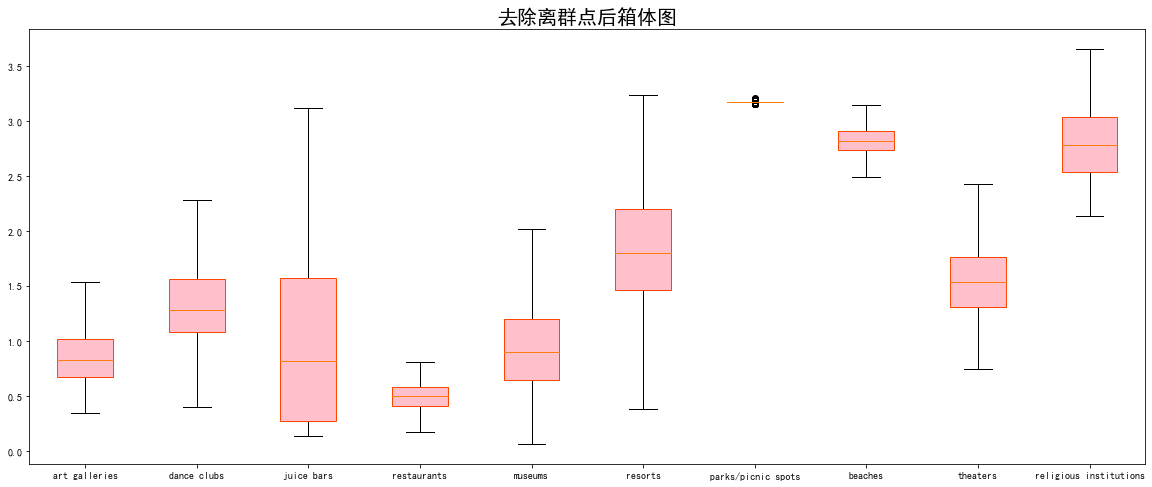

In [6]:
#设置大于上限的值为最大值，小于下限的值为最小值，从而修改离群点为正常点
for i in range(10):
    if i == 6: #第7个属性因为数据相当集中，差值较小，不必更改
        continue
    name = data.columns[i]
    #调用BoxFeature函数获得箱体图信息
    out_list,Error_Point_num = BoxFeature(data[name])
    maxnum = out_list[5] 
    minnum = out_list[1]
    for j in range(980):
        if data.iat[j,i]> maxnum :
            data.iat[j,i] = maxnum
        elif data.iat[j,i] < minnum:
            data.iat[j,i] = minnum   
labels = ["art galleries", "dance clubs", "juice bars", "restaurants", "museums", "resorts", "parks/picnic spots", "beaches", "theaters", "religious institutions"]
box = []
for i in range(10):
    box.append(data[data.columns[i]])
plt.title('去除离群点后箱体图',fontsize=20)#标题，并设定字号大小
p = plt.boxplot(box, labels = labels, patch_artist = True, boxprops = {'color':'orangered','facecolor':'pink'})

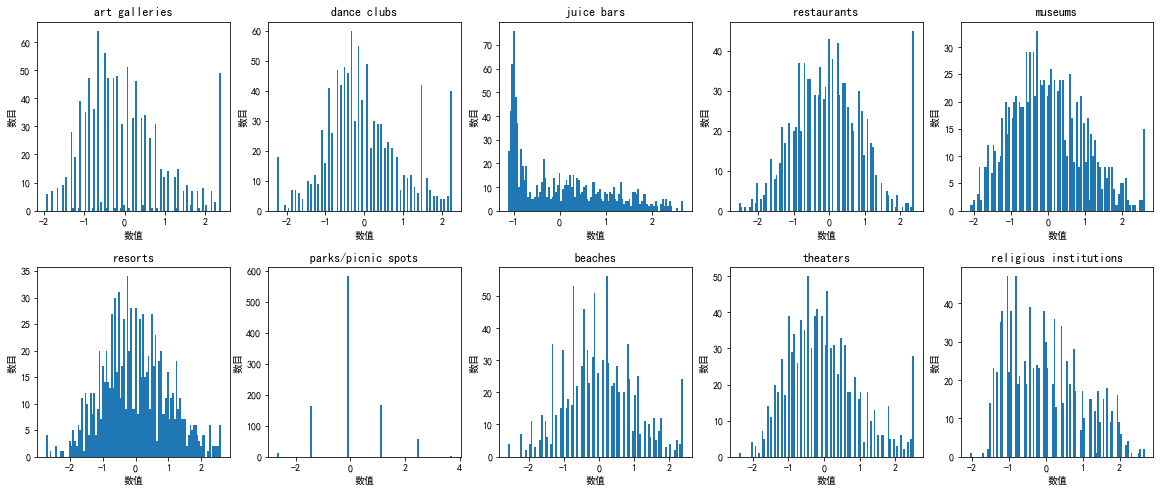

In [7]:
#归一化数据，方便之后的处理
fig, ax = plt.subplots(2,5)
plt.subplots_adjust(wspace=0.2, hspace=0.3)
values = data.astype(float) #dataframe转换为array
g = preprocessing.scale(values, axis=0, with_mean=True, with_std=True, copy=True)
data = pd.DataFrame(g)
data.columns = ["art galleries", "dance clubs", "juice bars", "restaurants", "museums", "resorts", "parks/picnic spots", "beaches", "theaters", "religious institutions"]
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.hist(data[data.columns[i]], bins=100)
    plt.ylabel("数目")
    plt.xlabel("数值")
    plt.title(data.columns[i])
plt.show()

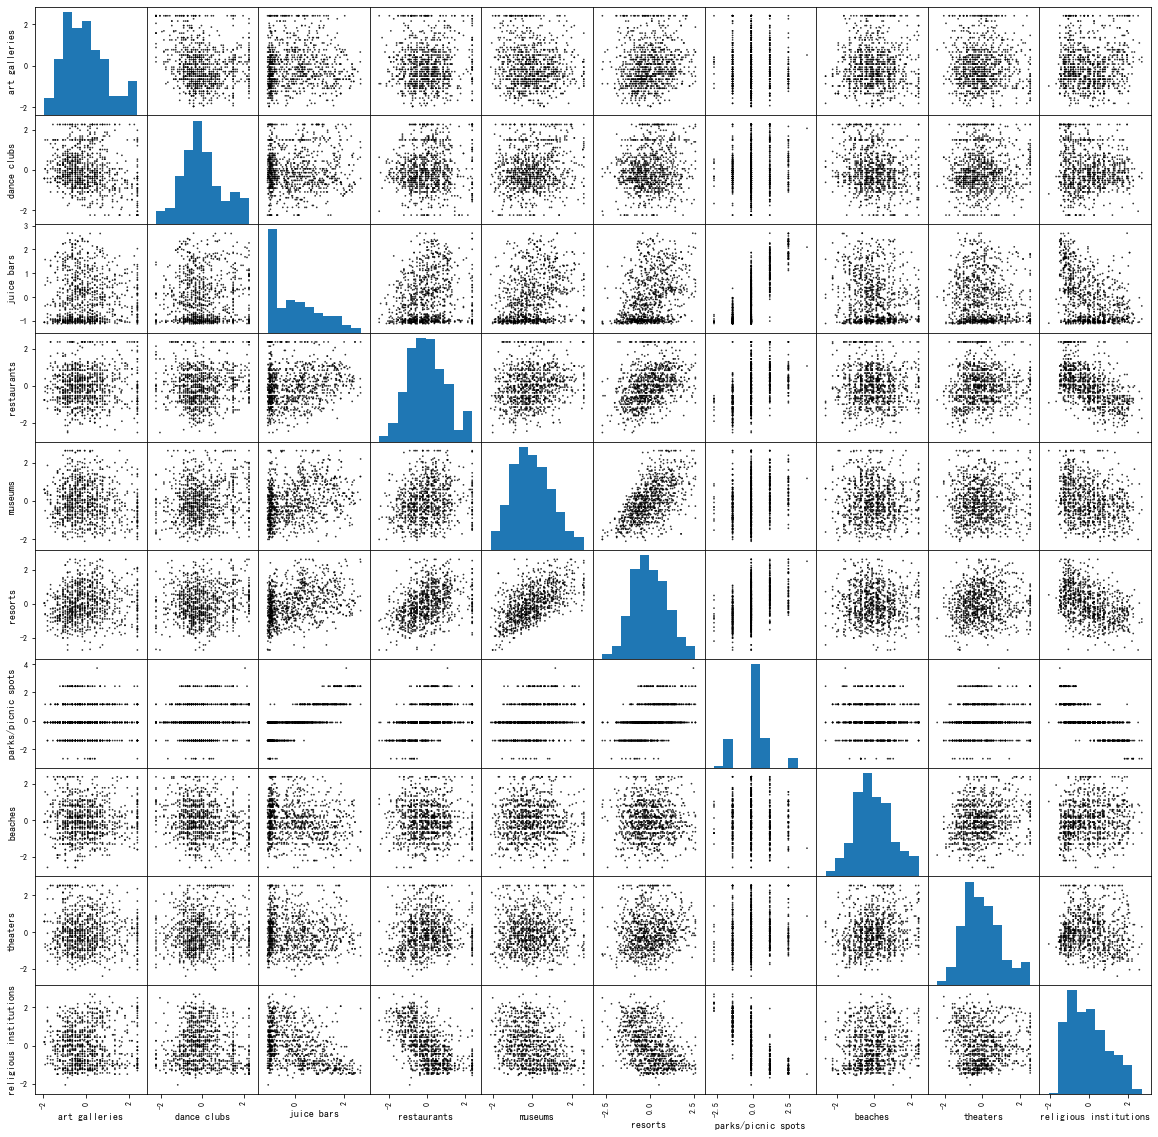

In [8]:
#查看每个属性之间是否存在关系，由相关性散点图可以看出来，10个属性之间的关系很小
pd.plotting.scatter_matrix(data, figsize=(20,20), c = 'k', marker = '0', s = 3, diagonal='hist', alpha = 0.8, range_padding=0.2)
plt.show()

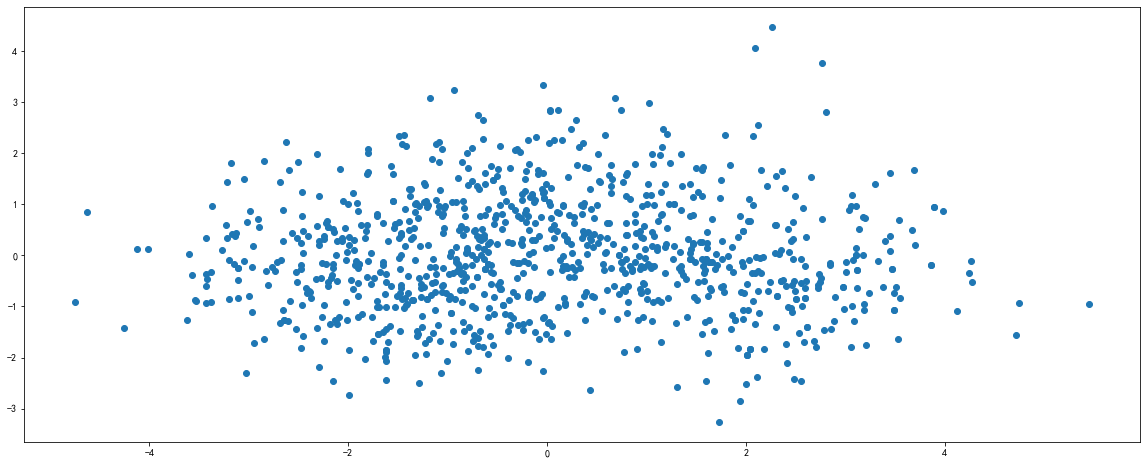

In [9]:
#2维下聚类处理
#进行降维
pca = PCA(n_components=2)
newdata = pca.fit_transform(data)

x = []
y = []

for i in range(len(newdata)):
    x.append(newdata[i][0])
    y.append(newdata[i][1])

plt.scatter(x, y)
plt.show()
#降到2维的结果

In [10]:
km_cluster = KMeans(n_clusters=2, max_iter=100, init='k-means++')
#K=2，最多迭代100次，按k-means++选初始点
predictions = km_cluster.fit_predict(newdata)
print('result:', predictions)
print('clusters: first classes: %d, second classes: %d' %
      (np.sum(predictions == 0), np.sum(predictions == 1)))
#聚类结果，以及每个类包含的数据个数

result: [0 0 1 1 0 1 1 1 0 1 0 1 0 0 0 0 1 0 0 0 1 1 1 1 0 0 0 0 1 0 0 0 0 0 1 1 1
 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1
 0 0 1 0 1 1 1 1 1 1 1 1 0 1 0 1 1 1 0 0 0 1 0 1 0 1 1 1 0 1 1 0 0 1 1 0 0
 1 0 0 0 0 0 1 1 1 0 0 0 0 0 1 1 0 1 1 1 0 0 0 1 0 0 0 1 1 1 1 1 1 1 1 0 0
 0 0 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 0 1 0 1 0 1 1 1 1 0 1 1 1 1 1 0 0 1 0
 1 1 1 0 1 0 0 1 1 1 1 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 0 0 0 1
 0 1 0 1 0 1 1 0 1 0 1 1 0 1 0 1 0 1 0 0 0 1 1 1 1 0 1 1 0 1 0 0 1 1 1 0 1
 0 0 0 1 0 1 0 0 0 1 0 1 1 0 0 0 1 0 0 1 1 1 1 0 0 1 1 0 1 1 1 0 1 1 1 1 0
 1 1 0 0 1 0 0 1 0 1 1 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 0 1 1 0 0 0 0 0 1 0 1
 0 1 0 0 1 0 1 0 0 1 0 1 1 0 1 0 0 1 1 0 1 1 1 0 1 0 1 1 0 0 1 0 0 0 1 1 0
 1 0 0 0 1 0 0 1 1 0 1 1 0 1 1 0 0 0 1 1 0 1 0 1 1 0 1 1 1 0 1 0 1 1 0 0 1
 0 0 0 1 0 0 0 0 0 1 1 1 0 0 1 0 1 1 0 0 1 1 1 0 0 0 0 0 1 1 0 1 1 1 1 1 1
 0 1 0 1 0 0 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 0 1 1 0 1 0 1 1 0 0 1
 0 1 0 0 1 1 1 1 

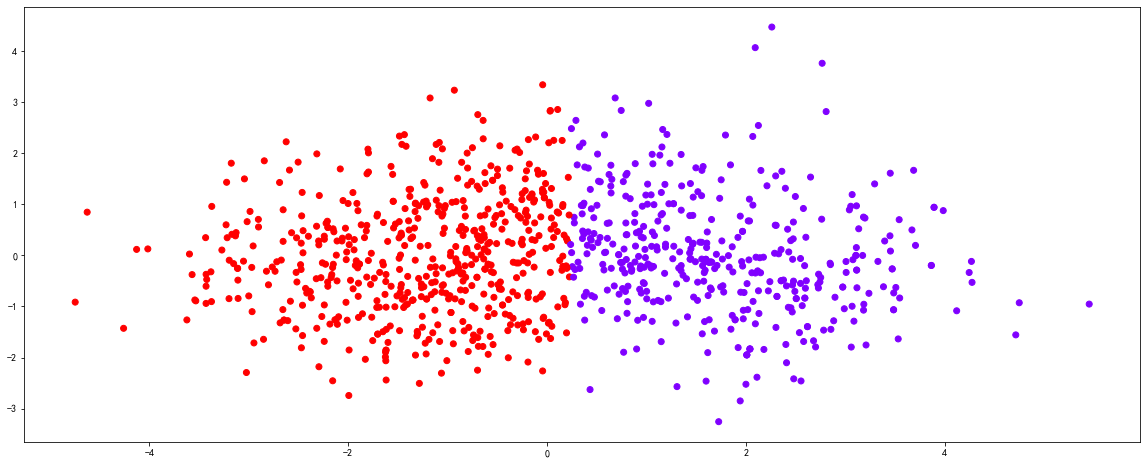

In [11]:
colors = cm.rainbow(np.linspace(0, 1, 2))
x = []
y = []
c = []

for i in range(len(newdata)):
    x.append(newdata[i][0])
    y.append(newdata[i][1])
    c.append(colors[predictions[i]])

plt.scatter(x, y, color=c)
plt.show()
#聚类结果可视化展示

In [12]:
km_cluster = KMeans(n_clusters=3, max_iter=300, init='k-means++')
#K=3，最多迭代300次，按k-means++选初始点
predictions = km_cluster.fit_predict(newdata)
print('result:', predictions)
print('clusters: first classes: %d, second classes: %d, thrid classes: %d' %
      (np.sum(predictions == 0), np.sum(predictions == 1), np.sum(predictions == 2)))
#聚类结果，以及每个类包含的数据个数

result: [1 1 0 2 1 2 2 2 1 2 0 2 1 1 1 1 2 1 0 1 2 2 2 2 0 1 1 1 2 1 1 1 1 0 0 0 2
 2 1 0 2 2 2 0 0 2 0 2 2 1 2 2 1 0 2 2 1 2 1 1 1 2 2 2 0 0 2 2 2 2 0 1 2 2
 1 1 2 1 2 2 0 0 2 0 0 2 0 2 1 2 0 2 1 1 1 0 1 0 0 0 0 2 1 2 2 1 0 2 2 1 0
 2 0 0 1 0 1 0 2 2 1 0 1 0 1 2 2 1 2 2 2 1 1 1 2 0 1 1 2 2 2 2 2 0 0 2 0 1
 0 1 0 2 2 2 2 2 0 2 1 2 2 2 0 2 2 2 1 0 1 0 0 0 2 2 0 1 0 0 0 0 0 1 0 2 1
 0 0 0 1 2 1 1 2 2 2 2 2 1 2 1 1 0 1 0 2 2 2 0 2 2 2 1 2 2 2 1 2 2 1 0 0 2
 1 2 1 2 1 2 2 1 0 1 2 2 0 2 0 0 0 2 1 1 0 2 2 2 0 1 2 2 1 2 1 1 2 0 2 1 0
 1 0 0 0 0 2 1 1 1 2 1 2 0 1 1 1 2 1 0 2 0 2 0 1 1 2 2 1 0 2 2 1 2 2 0 2 0
 2 2 0 1 2 1 1 2 0 2 0 1 0 1 2 2 2 1 1 0 1 2 1 2 0 0 1 2 0 1 1 1 1 0 0 1 0
 0 2 1 1 2 0 0 1 1 0 1 2 2 0 0 1 1 0 0 0 2 2 2 0 2 0 2 2 1 1 2 0 1 0 0 0 1
 2 1 0 1 0 1 1 2 0 1 2 2 0 2 2 1 1 0 2 2 1 2 1 2 0 1 2 0 2 0 0 1 0 2 1 1 2
 1 1 1 2 1 1 1 0 1 2 2 2 1 1 2 1 2 2 0 1 2 2 2 0 0 1 1 1 2 2 0 0 0 2 2 2 0
 1 2 1 2 1 0 2 2 0 1 0 2 0 2 1 2 0 2 0 0 0 1 2 0 2 2 1 2 2 0 2 0 2 2 1 1 0
 1 2 1 1 2 0 0 2 

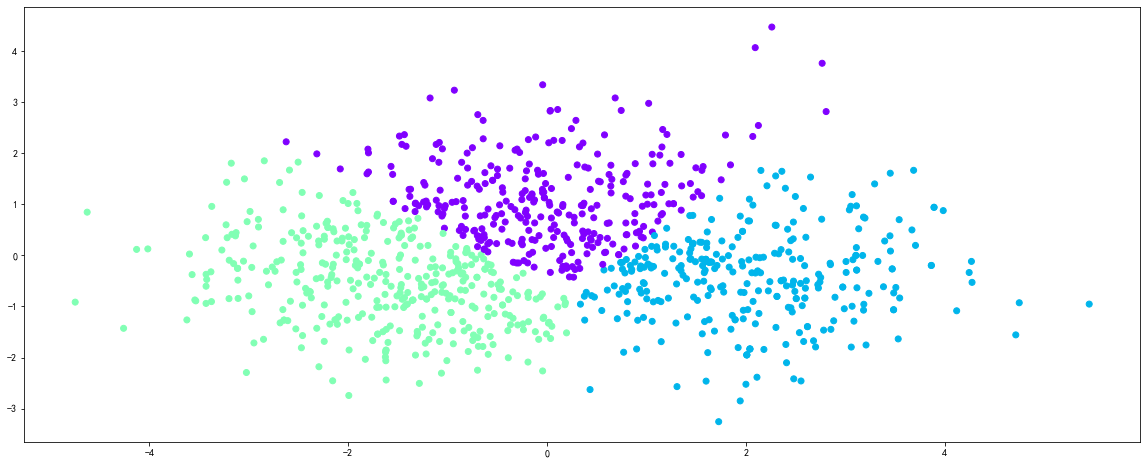

In [13]:
colors = cm.rainbow(np.linspace(0, 1, 5))
x = []
y = []
c = []

for i in range(len(newdata)):
    x.append(newdata[i][0])
    y.append(newdata[i][1])
    c.append(colors[predictions[i]])

plt.scatter(x, y, color=c)
plt.show()
#聚类结果可视化展示

In [14]:
################################
#Author: xu yangfan
#3维下聚类处理
#进行降维
pca = PCA(n_components=3)
newdata_3 = pca.fit_transform(data)
print(newdata_3)
x_3 = []
y_3 = []
z_3 = []

for i in range(len(newdata_3)):
    x_3.append(newdata_3[i][0])
    y_3.append(newdata_3[i][1])
    z_3.append(newdata_3[i][2]) 

[[ 2.59184019 -0.20296918  0.08722651]
 [ 5.455304   -0.95467443  0.3685248 ]
 [-0.7290039   0.48886999 -2.19707613]
 ...
 [-1.12985586 -0.71315165  0.79646405]
 [-2.21035459  0.66599755 -2.28901665]
 [ 1.01022272  0.99925137 -1.02221749]]


Text(0.5, 0, 'Z')

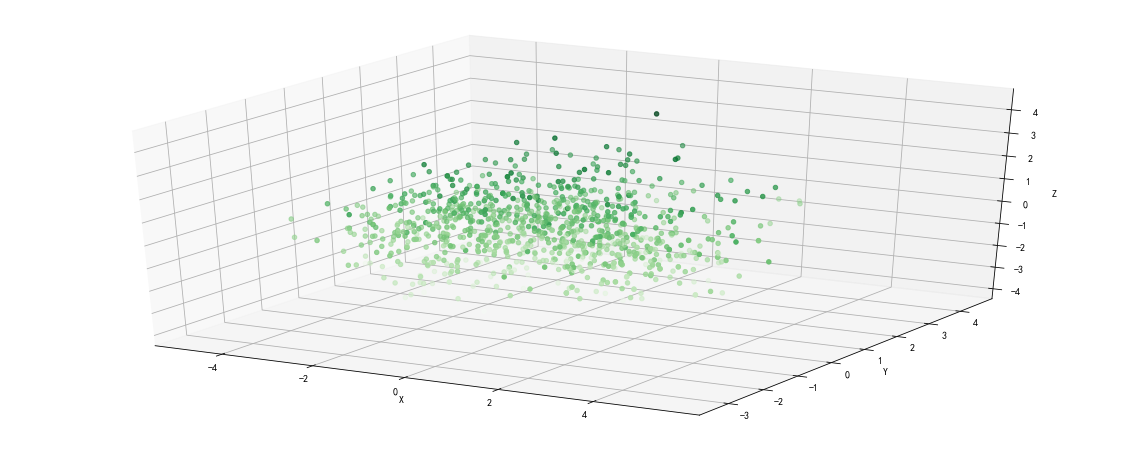

In [15]:
ax = plt.axes(projection='3d')
ax.scatter3D(x_3, y_3, z_3, c=z_3, cmap='Greens')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

#ax.view_init(60, 35)

In [16]:
km_cluster = KMeans(n_clusters=2, max_iter=300, init='k-means++')
#K=2，最多迭代100次，按k-means++选初始点
newdata_3_k2 = newdata_3
predictions = km_cluster.fit_predict(newdata_3_k2)
print('result:', predictions)
print('clusters: first classes: %d, second classes: %d' %
      (np.sum(predictions == 0), np.sum(predictions == 1)))
#聚类结果，以及每个类包含的数据个数

result: [0 0 1 1 0 1 1 1 0 1 0 1 0 0 0 0 1 0 0 0 1 1 1 1 0 0 0 0 1 0 0 0 0 0 1 1 1
 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1
 0 0 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 1 0 1 0 1 1 1 0 1 1 0 0 1 1 0 0
 1 0 0 0 0 0 1 1 1 0 0 0 0 0 1 1 0 1 1 1 0 0 0 1 0 0 0 1 1 1 1 1 1 1 1 0 0
 0 0 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 0 1 0 1 0 1 1 1 1 0 1 1 1 1 1 0 0 1 0
 1 1 1 0 1 0 0 1 1 1 1 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 0 0 0 1
 0 1 0 1 0 1 1 0 1 0 1 1 0 1 0 0 0 1 0 0 0 1 1 1 1 0 1 1 0 1 0 0 1 1 1 0 1
 0 0 0 1 0 1 0 0 0 1 0 1 1 0 0 0 1 0 0 1 1 1 1 0 0 1 1 0 0 1 1 0 1 1 1 1 0
 1 1 0 0 1 0 0 1 0 1 1 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 0 1 1 0 0 0 0 0 1 0 1
 0 1 0 0 1 0 1 0 0 1 0 1 1 0 1 0 0 1 1 0 1 1 1 0 1 0 1 1 0 0 1 0 0 0 1 1 0
 1 0 0 0 1 0 0 1 1 0 1 1 0 1 1 0 0 0 1 1 0 1 0 1 1 0 1 1 1 0 1 0 1 1 0 0 1
 0 0 0 1 0 0 0 0 0 1 1 1 0 0 1 0 1 1 1 0 1 1 1 0 0 0 0 0 1 1 0 1 1 1 1 1 1
 0 1 0 1 0 0 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 0 1 1 0 1 0 1 1 0 0 1
 0 1 0 0 1 1 1 1 

Text(0.5, 0, 'z')

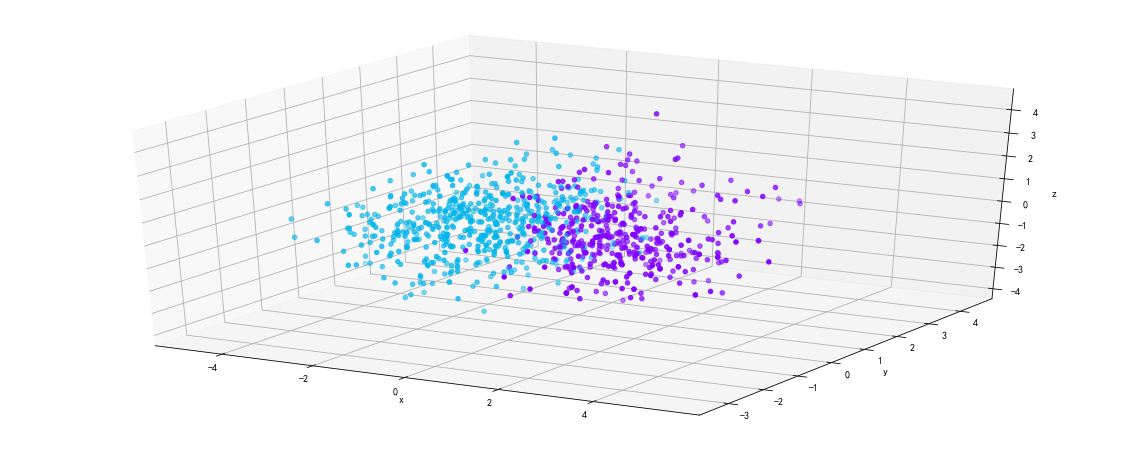

In [17]:
colors = cm.rainbow(np.linspace(0, 1, 5))
x_3_k2 = []
y_3_k2 = []
z_3_k2 = []
c_3_k2 = []

for i in range(len(newdata_3_k2)):
    x_3_k2.append(newdata_3_k2[i][0])
    y_3_k2.append(newdata_3_k2[i][1])
    z_3_k2.append(newdata_3_k2[i][2])
    c_3_k2.append(colors[predictions[i]])
ax = plt.axes(projection='3d')
ax.scatter3D(x_3_k2, y_3_k2, z_3_k2, c=c_3_k2);
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
#ax.view_init(60, 35)
#聚类结果可视化展示

In [18]:
km_cluster = KMeans(n_clusters=3, max_iter=500, init='k-means++')
newdata_3_k2 = newdata_3
predictions = km_cluster.fit_predict(newdata_3_k2)
print('result:', predictions)
print('clusters: first classes: %d, second classes: %d, third classes: %d' %
      (np.sum(predictions == 0), np.sum(predictions == 1), np.sum(predictions == 2)))
#聚类结果，以及每个类包含的数据个数

result: [2 2 0 1 2 1 1 1 2 1 0 1 2 2 2 2 1 2 0 2 1 1 1 1 0 2 2 2 1 2 2 2 2 0 0 0 1
 1 2 0 1 1 1 0 0 1 0 1 1 2 1 1 2 0 1 1 2 1 2 2 2 1 1 1 0 0 1 1 1 1 0 2 1 1
 2 2 1 2 1 1 0 0 1 0 0 1 0 1 2 1 0 1 2 2 2 0 2 0 0 0 0 1 2 1 1 2 0 1 1 2 0
 1 0 0 2 0 2 0 1 1 2 0 2 0 2 1 1 2 1 1 1 2 2 2 1 0 2 2 1 1 1 1 1 0 0 1 0 2
 0 2 0 1 1 1 1 1 0 1 2 1 1 1 0 1 1 1 2 0 2 0 0 0 1 1 0 2 0 0 0 0 0 2 0 1 2
 0 0 0 2 1 2 2 1 1 1 1 1 2 1 2 2 0 2 0 1 1 1 0 1 1 1 2 1 1 1 2 1 1 2 0 0 1
 2 1 2 1 2 1 1 2 0 2 1 1 0 1 0 0 0 1 2 2 0 1 1 1 0 2 1 1 2 1 2 2 1 0 1 2 0
 2 0 0 0 0 1 2 2 2 1 2 1 0 2 2 2 1 2 0 1 0 1 0 2 2 1 1 2 0 1 1 2 1 1 0 1 0
 1 1 0 2 1 2 2 1 0 1 0 2 0 2 1 1 1 2 2 0 2 1 2 1 0 0 2 1 0 2 2 2 2 0 0 2 0
 0 1 2 2 1 0 0 2 2 0 2 1 1 0 0 2 2 0 0 0 1 1 1 0 1 0 1 1 2 2 1 0 2 0 0 0 2
 1 2 0 2 0 2 2 1 0 2 1 1 0 1 1 2 2 0 1 1 2 1 2 1 0 2 1 0 1 0 0 2 0 1 2 2 1
 2 2 2 1 2 2 2 0 2 1 1 1 2 2 1 2 1 1 0 2 1 1 1 0 0 2 2 2 1 1 0 0 0 1 1 1 0
 2 1 2 1 2 0 1 1 0 2 0 1 0 1 2 1 0 1 0 0 0 2 1 0 1 1 2 1 1 0 1 0 1 1 2 2 0
 2 1 2 2 1 0 0 1 

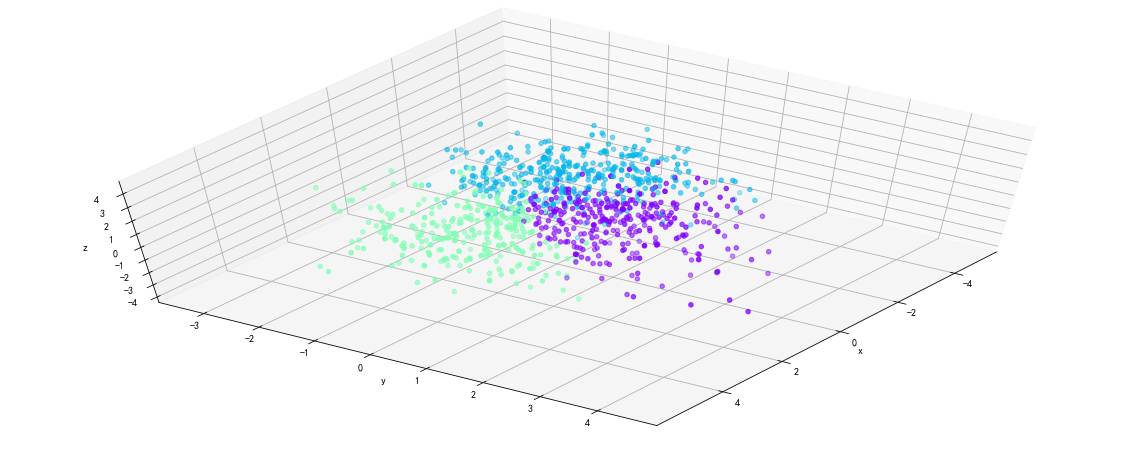

In [22]:
colors = cm.rainbow(np.linspace(0, 1, 5))
x_3_k3 = []
y_3_k3 = []
z_3_k3 = []
c_3_k3 = []

for i in range(len(newdata_3_k2)):
    x_3_k3.append(newdata_3_k2[i][0])
    y_3_k3.append(newdata_3_k2[i][1])
    z_3_k3.append(newdata_3_k2[i][2])
    c_3_k3.append(colors[predictions[i]])
ax = plt.axes(projection='3d')
ax.scatter3D(x_3_k3, y_3_k3, z_3_k3, c=c_3_k3);
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(60, 35)
